### Visual comparison of isopolygons calculated with Mapbox vs OsmIsopolygonCalculatorAlternative

In [1]:
%load_ext autoreload
%autoreload 2


from matplotlib import pyplot as plt
import networkx as nx
import osmnx as ox
import geopandas as gpd
import pandas as pd
from shapely import Polygon
from pisa.isopolygons import OsmIsopolygonCalculatorAlternative, OsmIsopolygonCalculator
from pisa.isopolygons_mapbox import MapboxIsopolygonCalculator


# run %pip install contextily first
import contextily



### Coordinates of actual hospital in Timor-Leste

In [2]:

hospital_coordinates = [
        (126.60048, -8.54733),
    ]

hospital_df = pd.DataFrame(hospital_coordinates, columns=["longitude", "latitude"])

# you need (latitude, longitude) for graph_from_point(), 
# in contrast to the (longitude, latitude) construction of facilities_df

hospital_lat_lon = (hospital_df.latitude.values[0], hospital_df.longitude.values[0])
hospital_lat_lon

(-8.54733, 126.60048)

### Auxiliary functions

In [11]:
unprojected_crs = "EPSG:4326"
web_mercator_crs = "EPSG:3857"

In [ ]:
def project_and_plot_isopolygon_exterior(isopolygon: Polygon):
    
    """Creates a GeoSeries from the isopolygon's exterior, projects it to web mercator CRS and plots it using contextily
    
    Remark: the isopolygon can have holes and they won't be visible in this plot
    """

    projected_poly_exterior = gpd.GeoSeries(isopolygon.exterior, crs=unprojected_crs).to_crs(web_mercator_crs)

    ax = projected_poly_exterior.plot(markersize=4, color="red")
    contextily.add_basemap(ax)
    plt.show()  


In [4]:
def calculate_isopolygon_area(isopolygon: Polygon) -> float: 
    """ 
    Takes a shapely Polygon, projects it to web mercator CRS and returns its area in sqm
    """

    return gpd.GeoSeries(isopolygon, crs=unprojected_crs).to_crs(web_mercator_crs).area[0]



### Mapbox isopolygon

In [ ]:
MAPBOX_TOKEN = "insert valid token here"

def get_mapbox_isopolygon(distance):

    mapbox_calculator = MapboxIsopolygonCalculator(
                facilities_df=hospital_df,
                distance_type="length",
                distance_values=[distance],
                route_profile="driving",
                mapbox_api_token=MAPBOX_TOKEN,
            )

    return mapbox_calculator.calculate_isopolygons()[f"ID_{distance}"].values[0]


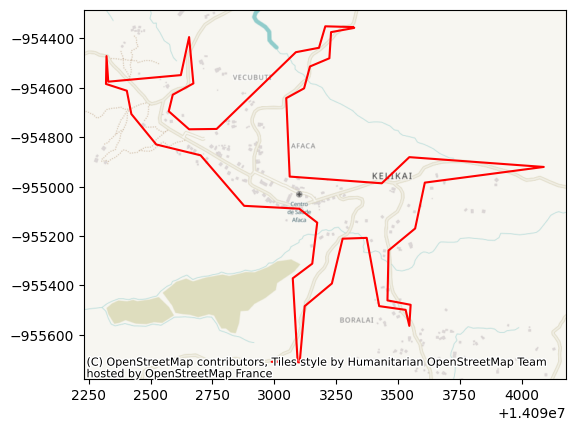

In [6]:
mapbox_iso_1000 = get_mapbox_isopolygon(1000)

project_and_plot_isopolygon_exterior(mapbox_iso_1000)

In [12]:
f"""At 1 km, The mapbox isopolygon's area is {calculate_isopolygon_area(mapbox_iso_1000):,.0f} sqm"""

"At 1 km, The mapbox isopolygon's area is 423,010 sqm"

### OSM

In [13]:
def isopolygon_osm_alternative(distance, buffer: float = 100) -> Polygon:

    """Returns the isopolygon around the hospital using the OsmIsopolygonCalculatorAlternative class"""
    

    road_network = ox.graph.graph_from_point(
    center_point=hospital_lat_lon, 
    dist=distance*5, # to compute isopolygon at 1 km, get road network 5 km around the point
    network_type="drive",
    )  

    return OsmIsopolygonCalculatorAlternative(
        facilities_df=hospital_df,
        distance_type="length",
        distance_values=[distance],
        road_network=road_network,
        buffer=buffer
    ).calculate_isopolygons()[f"ID_{distance}"].values[0]


    

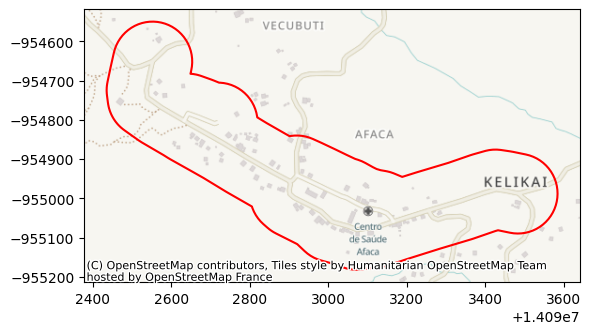

In [14]:
osm_iso_1000 = isopolygon_osm_alternative(1000)

project_and_plot_isopolygon_exterior(osm_iso_1000)

In [15]:
f"""At 1 km, the OSM isopolygon's area is {calculate_isopolygon_area(osm_iso_1000):,.0f} sqm"""

"At 1 km, the OSM isopolygon's area is 285,468 sqm"

### Let's inspect the OSM road network around the hospital

In [16]:
def draw_road_network_around_hospital(distance):

    road_network = ox.graph.graph_from_point(
    center_point=hospital_lat_lon, 
    dist=distance, # in meters
    network_type="drive",
    )    

    ox.plot_graph(road_network)

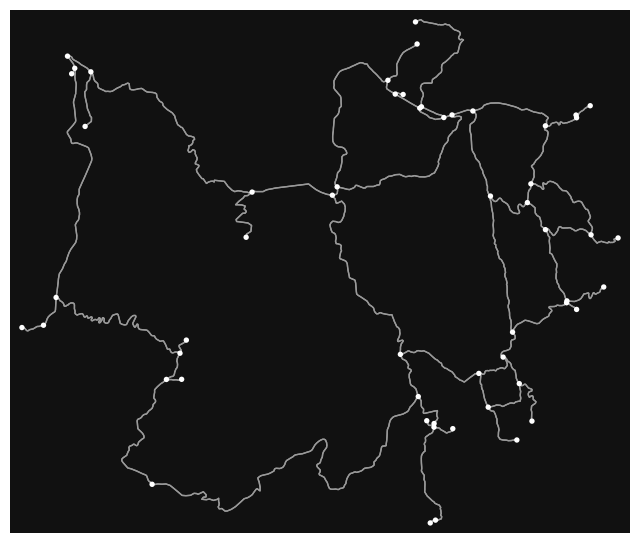

In [17]:
# I don't see any node or edge on the top right

draw_road_network_around_hospital(5000)

### Why are the mapbox and osm graphs so different?

##### 1. There is (apparently) no road node to the top right on osmnx. 

From the contextily map, it seems that one road is fully missing. 

Not much we can control there: the source could be missing data.

##### 2. On the bottom, we guess that the nodes were too far away to be included. 

Let's build the isopolygons with longer distances:



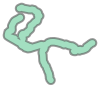

In [18]:
osm_iso_2000 = isopolygon_osm_alternative(distance=2000)
osm_iso_2000

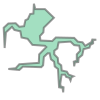

In [19]:
mapbox_iso_2000 = get_mapbox_isopolygon(distance=2000)
mapbox_iso_2000

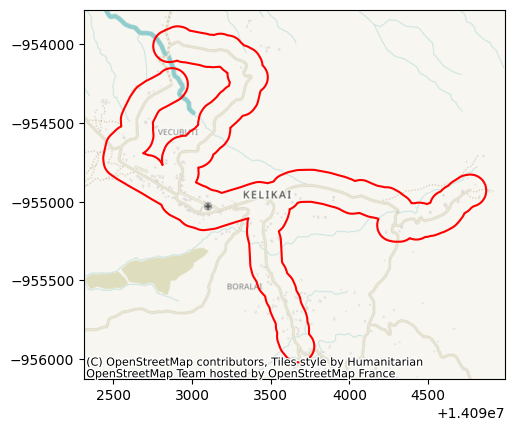

In [20]:
project_and_plot_isopolygon_exterior(osm_iso_2000)

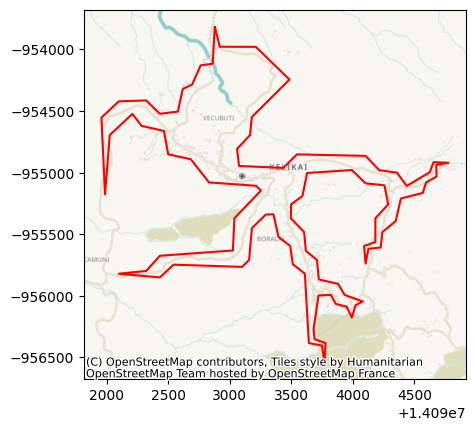

In [21]:
project_and_plot_isopolygon_exterior(mapbox_iso_2000)

Seems that our guess was correct, but needs verificaton by examining the network's roads and edges.

Key point of failure: ego_graph cuts off nodes that are too far away, but then the edges are kicked out too. And part of those edges (roads) should be included in the isopolygon.


TODO:

be mindful of how you construct the road network. In this case (single facility), we used graph_from_point(). In general, it's downloaded for the administrative area boundaries. However, if a facility is at the border with another region, a road could be missed if the other node end is in the bordering town.